# Análisis de las imágenes

## Carga del Dataset
Vamos a definir una clase, que tome como base la clase Dataset de Pytorch, para poder cargar todo nuestro conjunto de imágenes de uno o varios canales con su máscara correspondiente.

In [1]:
import os

print("Vamos a cambiar el directorio de trabajo")

# Indicamos la ruta del directorio de trabajo
route = os.getcwd() + "/TFG/test/PNe_segmentation"
os.chdir(route)

current_directory = os.getcwd()
print(" El directorio actual es:", current_directory)

# Listamos el contenido del directorio
files = os.listdir(current_directory)
print(" Contenido del directorio actual:")
for file in files:
    print("\t",file)
    
# Listamos el contenido del directorio de las máscaras
# masks_directory = route+"TFG\\test\\PNe_segmentation\\masks"
# data_directory = route+"TFG\\test\\PNe_segmentation\\data"
## Ejecución en el CESGA Finisterrae III
masks_directory = route+"/masks"
data_directory = route+"/data"


Vamos a cambiar el directorio de trabajo
 El directorio actual es: /mnt/netapp2/Home_FT2/home/ulc/co/ela/TFG/test/PNe_segmentation
 Contenido del directorio actual:
	 train_models
	 data
	 create_dataset.ipynb
	 data_files_1c.csv
	 images
	 image_analysis.ipynb
	 masks
	 segmentation_no_supervisada.ipynb
	 segmentation_no_supervisada_2c.ipynb
	 segmentation_no_supervisada_pytorch.ipynb
	 segmentation_supervisada.ipynb
	 dataset_info.csv
	 data_files_1c_train.csv
	 historico_notebooks
	 data_files_1c_test.csv
	 segmentation_no_supervisada_pytorch_clean.ipynb
	 segmentation_supervisada_pytorch copy.ipynb
	 segmentation_supervisada_pytorch.ipynb
	 cesga
	 segmentation_supervisada_pytorch copy 2.ipynb
	 segmentation_supervisada_pytorch copy 3.ipynb
	 data_files_1c_train_correct.csv


## Valor mínimo y máximo del dataset

In [2]:
from pnebulae_torch.dataset import NebulaeDataset
from pnebulae_torch.normalize import MinMaxImageNorm
from torchvision import transforms
import torch
import pandas as pd

# Creamos un objeto de la clase PNeDataset
transform_x = transforms.Compose([
                    transforms.Lambda(lambda x: torch.from_numpy(x.copy()).unsqueeze_(0))
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: torch.Tensor.int(x.round()))
                    ])

df_train = pd.read_csv("data_files_1c_train_correct.csv")
dataset_train = NebulaeDataset(data_directory, masks_directory, df_train, transform = (transform_x, transform_y))

Se utiliza el .csv corregido debido a que había una imagen con valores completamente atípicos y que no se veía nada visualmente hablando

In [3]:
min_values = []
max_values = []

for i in range(len(dataset_train)):
    min_values.append(dataset_train[i][0].min())
    max_values.append(dataset_train[i][0].max())

print("Min value:", min(min_values))
print("Max value:", max(max_values))

Min value: tensor(-88.9933)
Max value: tensor(125873.7500)


## Procesamiento de ventanas

In [4]:
from pnebulae_torch.dataset import NebulaeDataset
from pnebulae_torch.normalize import MinMaxImageNorm, TypicalImageNorm
from pnebulae_torch.preprocess import ApplyIntensityTransformation
from skimage import exposure
from torchvision import transforms
import torch
import pandas as pd

# Creamos un objeto de la clase PNeDataset
transform_x = transforms.Compose([
                    # MinMaxImageNorm(),
                    # TypicalImageNorm(),
                    ApplyIntensityTransformation(exposure.equalize_hist, nbins = 256),
                    transforms.ToTensor(),
                    # transforms.Lambda(lambda x: torch.from_numpy(x.copy()).unsqueeze_(0))
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: torch.Tensor.int(x.round()))
                    ])

df_train = pd.read_csv("data_files_1c_train_correct.csv")
dataset_train = NebulaeDataset(data_directory, masks_directory, df_train, transform = (transform_x, transform_y))

In [5]:
import matplotlib.pyplot as plt
import random as rd

window_size = 9

nebulae_windows = []
background_windows = []

for i, (image, mask) in enumerate(dataset_train):
    neb_index = (mask == 1).nonzero()
    back_index = (mask == 0).nonzero()

    cnt = 0
    mask_neb_window = torch.zeros(window_size, window_size)
    while mask_neb_window.sum() != window_size**2:
        rd_neb_pixel = neb_index[rd.randint(0, len(neb_index)-1)]
        image_neb_window = image[:, rd_neb_pixel[1]-window_size//2:rd_neb_pixel[1]+window_size//2+1, rd_neb_pixel[2]-window_size//2:rd_neb_pixel[2]+window_size//2+1]
        mask_neb_window = mask[:, rd_neb_pixel[1]-window_size//2:rd_neb_pixel[1]+window_size//2+1, rd_neb_pixel[2]-window_size//2:rd_neb_pixel[2]+window_size//2+1]
        cnt += 1
        if cnt > 1000:
            print("Error in image", i)
            break
    
    if cnt > 1000:
        continue
    
    mask_back_window = torch.ones(window_size, window_size)
    while mask_back_window.sum() != 0:
        rd_back_pixel = back_index[rd.randint(0, len(back_index)-1)]
        image_back_window = image[:, rd_back_pixel[1]-window_size//2:rd_back_pixel[1]+window_size//2+1, rd_back_pixel[2]-window_size//2:rd_back_pixel[2]+window_size//2+1]
        mask_back_window = mask[:, rd_back_pixel[1]-window_size//2:rd_back_pixel[1]+window_size//2+1, rd_back_pixel[2]-window_size//2:rd_back_pixel[2]+window_size//2+1]
        if image_back_window.shape != (1, window_size, window_size):
            mask_back_window = torch.ones(window_size, window_size)
    
    nebulae_windows.append(image_neb_window)
    background_windows.append(image_back_window)
    
nebulae_windows = torch.stack(nebulae_windows)
background_windows = torch.stack(background_windows)

Error in image 103


In [6]:
nebulae_stats = [(mean, std, minimo, maximo) for mean, std, minimo, maximo in zip(nebulae_windows.mean(dim = [1,2,3]), nebulae_windows.std(dim = [1,2,3]), nebulae_windows.min(dim = 3)[0].min(dim = 2)[0], nebulae_windows.max(dim = 3)[0].max(dim = 2)[0])]
background_stats = [(mean, std, minimo, maximo) for mean, std, minimo, maximo in zip(background_windows.mean(dim = [1,2,3]), background_windows.std(dim = [1,2,3]), background_windows.min(dim = 3)[0].min(dim = 2)[0], background_windows.max(dim = 3)[0].max(dim = 2)[0])]

Nebulae stats: (tensor(0.6329), tensor(0.2989), tensor([0.0326]), tensor([0.9920]))
Background stats: (tensor(0.7342), tensor(0.2496), tensor([0.0781]), tensor([0.9985]))
General image stats: tensor(0.5606) tensor(0.2828) tensor(1.2393e-05) tensor(1.)


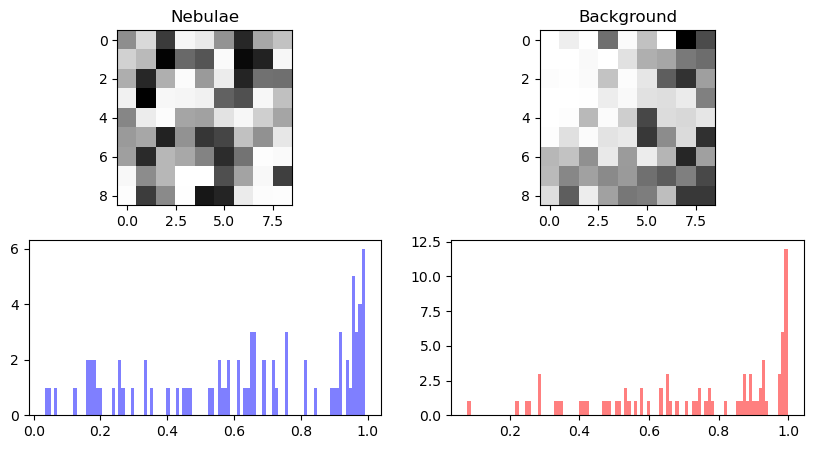

In [7]:
index = 2
print("Nebulae stats:", nebulae_stats[index])
print("Background stats:", background_stats[index])
print("General image stats:", dataset_train[index][0].mean(), dataset_train[index][0].std(), dataset_train[index][0].min(), dataset_train[index][0].max())
fig, axis = plt.subplots(2, 2, figsize = (10, 5))
axis[0,0].imshow(nebulae_windows[index][0], cmap = "gray")
axis[0,0].set_title("Nebulae")
axis[0,1].imshow(background_windows[index][0], cmap = "gray")
axis[0,1].set_title("Background")

axis[1,0].hist(nebulae_windows[index].flatten(), bins = 100, color = "blue", alpha = 0.5, label = "Nebulae")
axis[1,1].hist(background_windows[index].flatten(), bins = 100, color = "red", alpha = 0.5, label = "Background")

plt.show()


(array([  361.,    42.,    54.,    74.,    59.,    80.,    90.,    93.,
          118.,   117.,   165.,   165.,   159.,   192.,   209.,   220.,
          306.,   305.,   287.,   387.,   372.,   433.,   464.,   486.,
          555.,   622.,   652.,   729.,   743.,   860.,   897.,   915.,
         1013.,  1022.,  1130.,  1254.,  1331.,  1414.,  1471.,  1517.,
         1579.,  1719.,  1726.,  1902.,  1905.,  2000.,  2209.,  2324.,
         2311.,  2503.,  2507.,  2537.,  2602.,  2735.,  2709.,  2843.,
         2833.,  2986.,  2950.,  2993.,  3067.,  3090.,  3246.,  3167.,
         3111.,  3146.,  3249.,  3220.,  3159.,  3307.,  3219.,  3261.,
         3288.,  3129.,  3138.,  3158.,  3153.,  3131.,  3079.,  2997.,
         2913.,  2861.,  2811.,  2714.,  2724.,  2734.,  2657.,  2435.,
         2538.,  2390., 18061., 15888., 11516.,  8823.,  6753.,  5061.,
         3812.,  3011.,  2171.,  5676.]),
 array([0.12629321, 0.13503028, 0.14376734, 0.15250441, 0.16124149,
        0.16997856, 0.1787

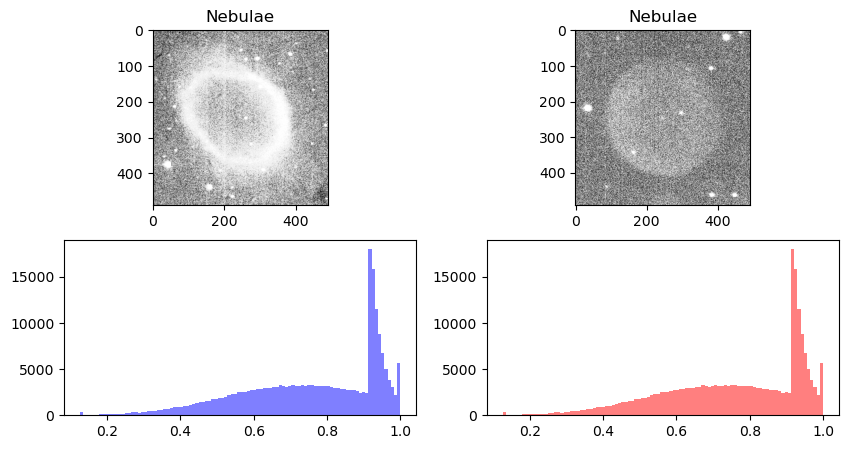

In [8]:
index_a = 0
index_b = 2

fig, axis = plt.subplots(2, 2, figsize = (10, 5))
axis[0,0].imshow(dataset_train[index_a][0][0], cmap = "gray")
axis[0,0].set_title("Nebulae")
axis[0,1].imshow(dataset_train[index_b][0][0], cmap = "gray")
axis[0,1].set_title("Nebulae")

axis[1,0].hist(dataset_train[index_a][0].flatten(), bins = 100, color = "blue", alpha = 0.5, label = "Nebulae")
axis[1,1].hist(dataset_train[index_a][0].flatten(), bins = 100, color = "red", alpha = 0.5, label = "Nebulae")
